# Introduction

### From binary classification to multi-class classification

In the previous notebook, we have seen how to build a binary classifier with SVM, PLA, or Logistic Regression. To open the door to multi-class classification, we have to extend the binary classifier to a multi-class classifier. There are two main strategies to do so:
- Combine multiple binary classifiers
- One-vs-one / One-vs-all

Or using Softmax

### End-to-end Machine Learning project

Softmax Regression is a layer of Neural Networks used in multi-class classification, often used in current classifiers. The best results are achieved through Neural Networks with many layers, including Convolutional Neural Networks. The layers before the last layer extract data features, while the last layer is a simple but effective linear classifier. The effectiveness of Softmax Regression and Convolutional Neural Networks lies in the simultaneous training of both the feature extractor and classifier. This end-to-end model complements each other during the training process, making it ideal for machine learning problems.

With the development of Deep Learning in recent years, it is believed that end-to-end systems provide better results because the two blocks above are trained together, complementing each other. In fact, state-of-the-art methods are often end-to-end models.

Support Vector Machine methods have been shown to outperform Logistic Regression because they care about creating the largest margin between classes. The question is:

Is there a way to combine SVM with Neural Networks to create a good classifier for multi-class classification? Furthermore, can the entire system be trained end-to-end?

The answer is yes, and this is the goal of this notebook. We will build a multi-class classifier using SVM.

### The CIFAR-10 dataset

The CIFAR10 database consists of 51,000 different images belonging to 10 classes: plane, car, bird, cat, deer, dog, frog, horse, ship, and truck. Each image is 32 × 32 pixels in size. Some examples for each class are given in Figure 2 below. 50,000 images are used for training, and the remaining 1,000 images are used for testing. Out of the 50,000 training images, 1,000 images are randomly selected to form the validation set.

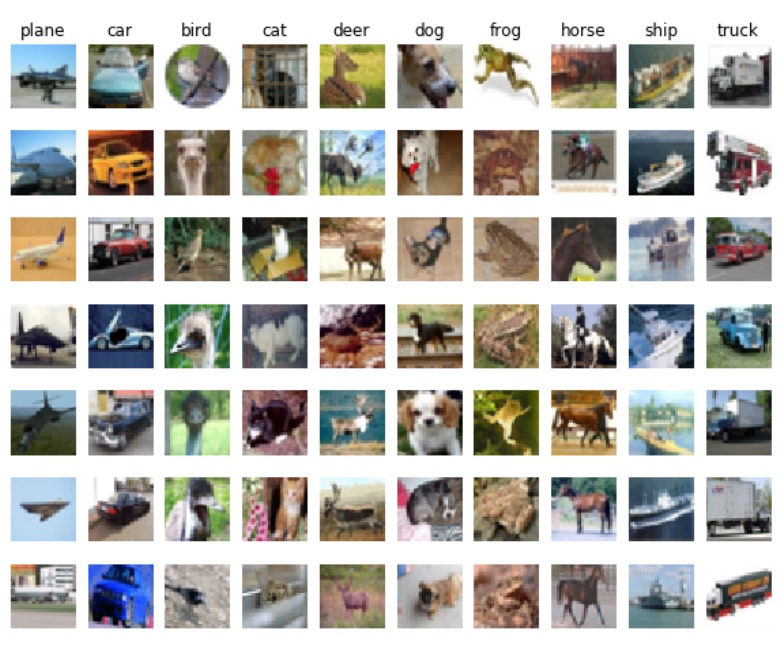

This is a relatively difficult database because small images and objects in the same class also vary a lot in color, shape, and size. The best algorithm currently available for this problem has achieved over 90% accuracy, using a multi-layer Convolutional Neural Network combined with Softmax regression in the last layer. In this article, we will use a simple neural network model without any hidden layers to solve it, the result is about 40%, but it is still very impressive.

This problem as well as the main content of the article are taken from Lecture notes: Linear Classifier II and Assignment #1 in the course CS231n: Convolutional Neural Networks for Visual Recognition Winter 2016 of Stanford.

### Image processing

To start, we will load the whole dataset and preprocess it just by a little bit.:
- Each images is a 32x32x3 numpy array, so the size of the input data is 32x32x3 = 3072
- Each pixel value run from 0 to 255, we will normalize it to run from -1 to 1

### Bias trick

Typically, with a coefficient matrix $W \in \mathbb{R}^{d \times C}$, a input $x \in \mathbb{R}^d$ and vector bias $b \in \mathbb{R}^C$, we can calculate this output of the first layer:

$$f(x, W, b) = W^Tx + b$$

To make the equation more compact, we can add a constant 1 to the input $x$ and add vector $b$ to the matrix $W$:

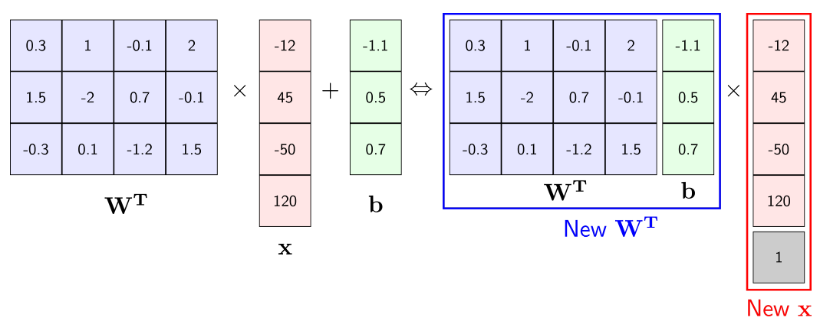

Now we only have 1 variable $w$ instead of two like before. This trick is called the bias trick.

# Loss function for Multi-class SVM

### Recall Softmax Regression

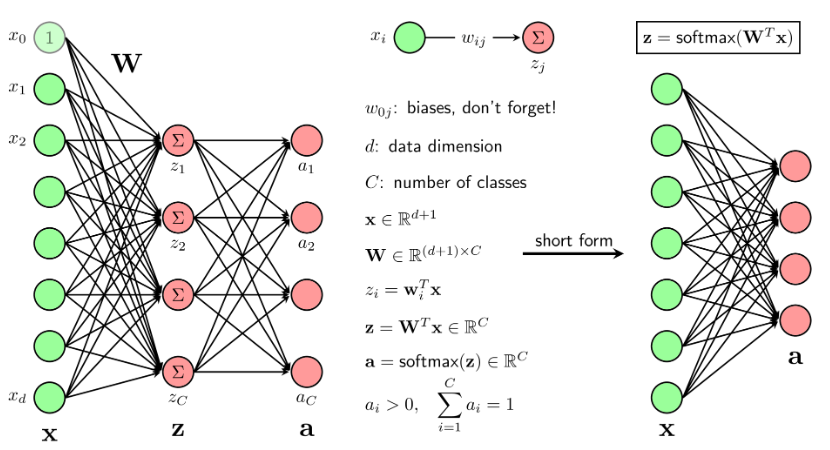

In the picture above, dataset in green called feature vector. With CIFAR-10, if we consider each feature is a pixel, then the overall feature vector is a $32 \times 32 \times 3 + 1 = 3073$, with 3 channels for each pixel.

By coefficient matrix $W$, the original data is transformed into $z = W^Tx$

Now, with each data in class C respectively, we recieve a score corresponding to $z_i$ for class $i$.

The main idea in Softmax Regression is to find coefficients matrix $W$, each columns of this matrix represent for a class, which vector $z$ has the highest score.

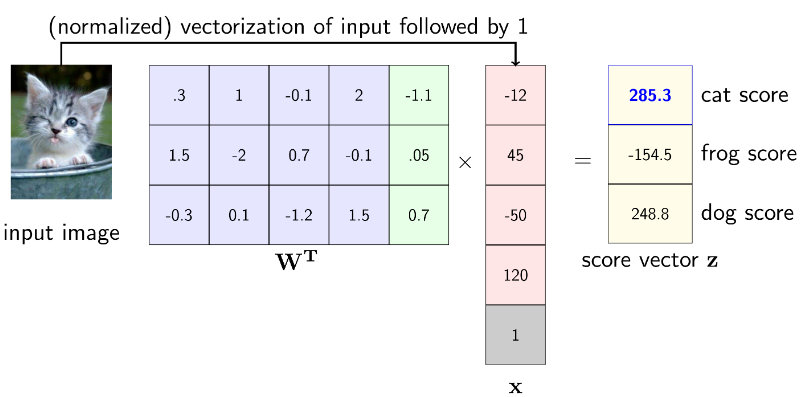

To training, the model using Softmax to pull score vector into a probability distribution vector, have sum of all elements equal to 1. Then use cross-entropy loss function to calculate the difference between the predicted probability distribution and the true distribution - thus one-hot encoding.

### Hinge loss for Multi-class SVM

With Multi-class SVM, when testing, class of a input can be identified by the class has the highest score. 

While softmax using cross-entropy to force two vector probability distribution to be the same, Multi-class SVM using another strategy for the same purpose. But the different is Multi-class SVM build loss function based on the definition of *safe margin*, like Hard/Soft margin, it's want the component corresponding to the correct class of the score vector to be larger than the other elements, and not only that, it is also larger than a quantity of $\Delta > 0$.

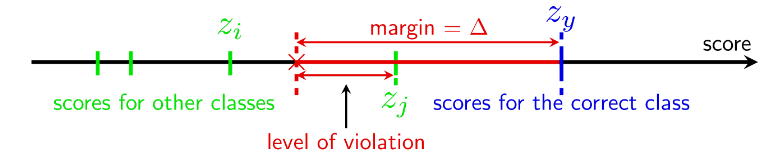

With the above boundary determination, Multi-class SVM will ignore scores that lie in front of the red area. Scores that lie to the right of the threshold (red x) will be penalized, and the more violations, the higher the penalty level.

To describe these violation levels mathematically, we first assume that the components of the score vector are numbered starting from 1. The classes are also numbered starting from 1. Suppose that the data point $x$ belong to class $y$ and score vector is $z$. Then score of the correct class is $z_y$, other is $z_{\neq y}$.

- With each score $z_i$ under the safe margin, loss equal to 0
- With each score $z_i$ over the safe margin, loss made by it can be calculated by the amount of excess over the red point $x$: $z_j - (z_y - \Delta) = \Delta - z_y + z_j$

To summary, it can be written as:

$$\max(0, z_j - z_y + \Delta) = \max(0, \Delta - w_y^Tx + w_j^Tx) \tag{1}$$ 

Where $w_j$ is the $j$-th column of the matrix $W$.

Then with  each data point $x_n, n = 1, 2, \cdots, N$, the loss function can be written as:

$$\mathcal{L_n} = \sum_{j \neq y} \max(0, \Delta - z_{y_n}^n + z_j^n)$$

Where $z^n = w^Tx_n = [z_1^n, z_2^n, \cdots, z_C^n]$ is the score vector of the data point $x_n$ (correct class is $y_n$).

With every data point, loss will be:

$$\mathcal{L}(X, y, W) =  \frac{1}{N} \sum_{n=1}^N \sum_{j \neq y} \max(0, \Delta - z_{y_n}^n + z_j^n) \tag{2}$$

And there's a **bug** in the above formula. Can you find it?

### Regularization

What happen if the solution $w$ is unique, thus no score can violate the formula $(2)$ to make it $0$?

$$\Delta - z_{y_n}^n + z_{j}^n \leq 0 \Leftrightarrow \Delta \leq w_{y_n}^Tx_n - w_{j}^Tx_n, \forall j \neq y_n$$

This mean $kW$ also is a solution, with $k > 1$. The fact that the problem has infinitely many solutions and that some of the solutions have elements that go to infinity makes the problem very unstable to solve. A common method to avoid this is to add a regularization term to the loss function. This term prevents the coefficients of $W$ from becoming too large. The regularization term is usually the sum of the squares of the elements of $W$:

$$\mathcal{L}(X, y, W) = \underbrace{\frac{1}{N} \sum_{n=1}^{N} \sum_{\substack{j \neq y_n}} \max(0, \Delta - w_{y_n}^T x_n + w_j^T x_n)}_{\text{data loss}} + \underbrace{\frac{\lambda}{2} \| W \|_F^2}_{\text{regularization loss}}
\tag{3}$$

With $\|W\|_F^2$ is Frobenius norm of matrix $W$. $\lambda$ is a positive hyperparameter, which is used to adjust the importance of the regularization term. Which can be choose by cross-validation.

### Choosing $\Delta$

There's two hyperparameter in loss $(3)$ is $\Delta$ and $\lambda$. The question is how to choose them? Do we have to using cross-validation for each of them?

In reality, the choice of $\Delta$ is not very important. $\Delta$ can be set to $1$ without affecting the results. It's show that both $\Delta$ and $\lambda$ help to improve balance between the data loss and the regularization loss. Indeed, the magnitude of the coefficients in $W$ has a direct impact on the score vectors, and thus the difference between them. When we reduce the coefficients of $W$, the difference between the score vectors also decreases, the same thing also happens, but in the opposite direction.

Therefore, the choice of $\Delta$ becomes less important, and the choice of $\lambda$ is more important.

$$\mathcal{L}(X, y, W) = \frac{1}{N} \sum_{n=1}^{N} \sum_{\substack{j \neq y_n}} \max(0, 1 - w_{y_n}^T x_n + w_j^T x_n) + \frac{\lambda}{2} \| W \|_F^2 \tag{4}$$

### Soft Margin SVM is a special case of Multi-class SVM

This statement seems obvious because the classification problem with two classes is a special case of the classification problem with many classes! But what I want to talk about is how to construct the loss function. This can be seen by looking at each data point.

In $(4)$, if $C = 2$, The loss function at each data point becomes (ignoring regularization loss for now):

$$\mathcal{L}(X, y, W) = \frac{1}{N} \sum_{n=1}^{N} \max(0, 1 - w_{y_n}^T x_n + w_j^T x_n) \tag{5}$$

Consider two cases:
- $y_n = 1 \Rightarrow \mathcal{L_n} = max(0, 1 - w_1^Tx_n + w_2^Tx_n) = max(0, 1 - (1)(w_1 - w_2)^Tx_n)$
- $y_n = 2 \Rightarrow \mathcal{L_n} = max(0, 1 - w_2^Tx_n + w_1^Tx_n) = max(0, 1 - (-1)(w_2 - w_1)^Tx_n)$

If we replace $y_n = -1$ for class 2, and set $\bar{w} = w_1 - w_2. then they can be written as:

$$\mathcal{L_n} = max(0, 1 - y_n \bar{w}^Tx_n)$$

thus Hinge loss for Soft Margin SVM is a special case of Multi-class SVM.